# Assignment 2

**Due to**: 23/12/2021 (dd/mm/yyyy)

**Credits**: Andrea Galassi, Federico Ruggeri, Paolo Torroni

**Summary**: Fact checking, Neural Languange Inference (**NLI**)

# Intro

This assignment is centred on a particular and emerging NLP task, formally known as **fact checking** (or fake checking). As AI techniques become more and more powerful, reaching amazing results, such as image and text generation, it is more than ever necessary to build tools able to distinguish what is real from what is fake.

Here we focus on a small portion of the whole fact checking problem, which aims to determine whether a given statement (fact) conveys a trustworthy information or not. 

More precisely, given a set of evidences and a fact to verify, we would like our model to correctly predict whether the fact is true or fake.

In particular, we will see:

*   Dataset preparation (analysis and pre-processing)
*   Problem formulation: multi-input binary classification
*   Defining an evaluation method
*   Simple sentence embedding
*   Neural building blocks
*   Neural architecture extension

# The FEVER dataset

First of all, we need to choose a dataset. In this assignment we will rely on the [FEVER dataset](https://fever.ai).

The dataset is about facts taken from Wikipedia documents that have to be verified. In particular, facts could face manual modifications in order to define fake information or to give different formulations of the same concept.

The dataset consists of 185,445 claims manually verified against the introductory sections of Wikipedia pages and classified as ```Supported```, ```Refuted``` or ```NotEnoughInfo```. For the first two classes, systems and annotators need to also return the combination of sentences forming the necessary evidence supporting or refuting the claim.

## 2.1 Dataset structure

Relevant data is divided into two file types. Information concerning the fact to verify, its verdict and associated supporting/opposing statements are stored in **.jsonl** format. In particular, each JSON element is a python dictionary with the following relevant fields:

*    **ID**: ID associated to the fact to verify.

*    **Verifiable**: whether the fact has been verified or not: ```VERIFIABLE``` or ```NOT VERIFIABLE```.
    
*    **Label**: the final verdict on the fact to verify: ```SUPPORTS```, ```REFUTES``` or ```NOT ENOUGH INFO```.
    
*    **Claim**: the fact to verify.
    
*    **Evidence**: a nested list of document IDs along with the sentence ID that is associated to the fact to verify. In particular, each list element is a tuple of four elements: the first two are internal annotator IDs that can be safely ignored; the third term is the document ID (called URL) and the last one is the sentence number (ID) in the pointed document to consider.

**Some Examples**

---

**Verifiable**

```
{"id": 202314, "verifiable": "VERIFIABLE", "label": "REFUTES", "claim": "The New Jersey Turnpike has zero shoulders.", "evidence": [[[238335, 240393, "New_Jersey_Turnpike", 15]]]}
```

---

**Not Verifiable**

```
{"id": 113501, "verifiable": "NOT VERIFIABLE", "label": "NOT ENOUGH INFO", "claim": "Grease had bad reviews.", "evidence": [[[133128, null, null, null]]]}
```

---

## 2.2 Some simplifications and pre-processing

We are only interested in verifiable facts. Thus, we can filter out all non-verifiable claims.

Additionally, the current dataset format does not contain all necessary information for our classification purposes. In particular, we need to download Wikipedia documents and replace reported evidence IDs with the corresponding text.

Don't worry about that! We are providing you the already pre-processed dataset so that you can concentrate on the classification pipeline (pre-processing, model definition, evaluation and training).

You can download the zip file containing all set splits (train, validation and test) of the FEVER dataset by clicking on this [link](https://drive.google.com/file/d/1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1/view?usp=sharing). Alternatively, run the below code cell to automatically download it on this notebook.

**Note**: each dataset split is in .csv format. Feel free to inspect the whole dataset!

In [4]:
import os
import requests
import zipfile

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = "1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1"
    toy_url = "https://docs.google.com/uc?export=download"

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print("Downloading FEVER data splits...")
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print("Download completed!")

        print("Extracting dataset...")
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print("Extraction completed!")

download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


# Classification dataset

At this point, you should have a reay-to-go dataset! Note that the dataset format changed as well! In particular, we split the evidence set associated to each claim, in order to build `(claim, evidence)` pairs. The classification label is propagated as well.

We'll motivate this decision in the next section!

Just for clarity, here's an example of the pre-processed dataset:

---

**Claim**: "Wentworth Miller is yet to make his screenwriting debut."

**Evidence**: "2	He made his screenwriting debut with the 2013 thriller film Stoker .	Stoker	Stoker (film)"

**Label**: Refutes

---

[**Note**]: The dataset requires some text cleaning as you may have noticed!


# Problem formulation

As mentioned at the beginning of the assignment, we are going to formulate the fact checking problem as a binary classification task.

In particular, each dataset sample is comprised of:

*     A claim to verify
*     A set of semantically related statements (evidence set)
*     Fact checking label: either evidences support or refute the claim.

Handling the evidence set from the point of view of neural models may imply some additional complexity: if the evidence set is comprised of several sentences we might incur in memory problems.

To this end, we further simplify the problem by building (claim, evidence) pairs. The fact checking label is propagated as well.

Example:

     Claim: c1 
     Evidence set: [e1, e2, e3]
     Label: S (support)

--->

    (c1, e1, S),
    (c1, e2, S),
    (c1, e3, S)

## 4.1 Schema

The overall binary classification problem is summed up by the following (simplified) schema

![](https://drive.google.com/uc?export=view&id=1Wm_YBnFwgJtxcWEBpPbTBEVkpKaL08Jp)

Don't worry too much about the **Encoding** block for now. We'll give you some simple guidelines about its definition. For the moment, stick to the binary classification task definition where, in this case, we have 2 inputs: the claim to verify and one of its associated evidences.

# Architecture Guidelines

There are many neural architectures that follow the above schema. To avoid phenomena like the writer's block, in this section we are going to give you some implementation guidelines.

In particular, we would like you to test some implementations so that you explore basic approaches (neural baselines) and use them as building blocks for possible extensions.

## 5.1 Handling multiple inputs

The first thing to notice is that we are in a multi-input scenario. In particular, each sample is comprised of a fact and its asssociated evidence statement.

Each of these input is encoded as a sequence of tokens. In particular, we will have the following input matrices:

*    Claim: `[batch_size, max_tokens]`
*    Evidence: `[batch_size, max_tokens]`

Moreover, after the embedding layer, we'll have:

*    Claim: `[batch_size, max_tokens, embedding_dim]`
*    Evidence: `[batch_size, max_tokens, embedding_dim]`

But, we would like to have a 2D input to our classifier, since we have to give an answer at pair level. Therefore, for each sample, we would expect the following input shape to our classification block:

*   Classification input shape: `[batch_size, dim]`

**How to do that?**

We inherently need to reduce the token sequence to a single representation. This operation is formally known as **sentence embedding**. Indeed, we are trying to compress the information of a whole sequence into a single embedding vector.

Here are some simple solutions that we ask you to try out:

1.   Encode token sequences via a RNN and take the last state as the sentence embedding.

2.  Encode token sequences via a RNN and average all the output states.

3.  Encode token sequences via a simple MLP layer. In particular, if your input is a `[batch_size, max_tokens, embedding_dim]` tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a `[batch_size, embedding_dim]` 2D matrix. Alternatively, you can reshape the 3D input tensor from `[batch_size, max_tokens, embedding_dim]` to `[batch_size, max_tokens * embedding_dim]` and then apply the MLP layer.

4.   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

## 5.2 Merging multi-inputs

At this point, we have to think about **how** we should merge evidence and claim sentence embeddings.

For simplicity, we stick to simple merging strategies:

*     **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings

*     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings

*     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings

For clarity, if the sentence embedding of a single input has shape `[batch_size, embedding_dim]`, then the classification input has shape:

*     **Concatenation**: `[batch_size, 2 * embedding_dim]`

*     **Sum**: `[batch_size, embedding_dim]`

*     **Mean**: `[batch_size, embedding_dim]`

# A simple extension

Lastly, we ask you to modify previously defined neural architectures by adding an additional feature to the classification input.

We would like to see if some similarity information between the claim to verify and one of its associated evidence might be useful to the classification.

Compute the cosine similarity metric between the two sentence embeddings and concatenate the result to the classification input.

For clarity, since the cosine similarity of two vectors outputs a scalar value, the classification input shape is modified as follows:

*     **Concatenation**: `[batch_size, 2 * embedding_dim + 1]`

*     **Sum**: `[batch_size, embedding_dim + 1]`

*     **Mean**: `[batch_size, embedding_dim + 1]`



# Performance evaluation

Due to our simplifications, obtained results are not directly compatible with a traditional fact checking method that considers the evidence set as a whole.

Thus, we need to consider two types of evaluations.

---

A. **Multi-input classification evaluation**

This type of evaluation is the easiest and concerns computing evaluation metrics, such as accuracy, f1-score, recall and precision, of our pre-processed dataset.

In other words, we assess the performance of chosen classifiers.

---

B. **Claim verification evaluation**

However, if we want to give an answer concerning the claim itself, we need to consider the whole evidence set. 

Intuitively, for a given claim, we consider all its corresponding (claim, evidence) pairs and their corresponding classification outputs. 

At this point, all we need to do is to compute the final predicted claim label via majority voting.

---

Example:

    Claim: c1
    Evidence set: e1, e2, e3
    True label: S

    Pair outputs:
    (c1, e1) -> S (supports)
    (c1, e2) -> S (supports)
    (c1, e3) -> R (refutes)

    Majority voting:
    S -> 2 votes
    R -> 1 vote

    Final label:
    c1 -> S

Lastly, we have to compute classification metrics just like before.

Shortly speaking, implement both strategies for your classification metrics.

# Tips and Extras

## 8.1 Extensions are welcome!

Is this task too easy for you? Are you curious to try out things you have seen during lectures (e.g. attention)? Feel free to try everything you want!

**Don't forget to try neural baselines first!**

## 8.2 Comments and documentation

Remember to properly comment your code (it is not necessary to comment each single line) and don't forget to describe your work!

## 8.3 Organization

We suggest you to divide your work into sections. This allows you to build clean and modular code, as well as easy to read and to debug.

A possible schema:

*   Dataset pre-processing
*   Dataset conversion
*   Model definition
*   Training
*   Evaluation
*   Comments/Summary

# Evaluation

Which are the evaluation criteria on which we'll judge you and your work?

1. Pre-processing: whether you have done some pre-processing or not.
2. Sentence embedding: you should implement all required strategies (with an example and working code for each). That is, we, as evaluators, should be able to test all strategies without writing down new code.
3. Multiple inputs merging strategies: you should implement all required strategies (with an example and working code for each).
4. Similarity extension: you should implement the cosine similarity extension (with an example and working code).
5. Voting strategy: you should implement the majority voting strategy and provide results.
6. Report: when submitting your notebook, you should also attach a small summary report that describes what you have done (provide motivations as well for abitrary steps. For instance, "We've applied L2 regularization since the model was overfitting".

Extras (possible extra points):

1. Any well defined extension is welcome!
2. Well organized and commented code is as important as any other criteria.

# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

* Andrea Galassi -> a.galassi@unibo.it
* Federico Ruggeri -> federico.ruggeri6@unibo.it

Professor:

* Paolo Torroni -> p.torroni@unibo.it

*Note*: We highly recommend you to check the [course useful material](https://virtuale.unibo.it/pluginfile.php/1036039/mod_resource/content/2/NLP_Course_Useful_Material.pdf) for additional information before contacting us!

# FAQ

---

**Question**: Can I do something text pre-processing?

**Answer:** You have to! If you check text data, the majority of sentences need some cleaning.

---

**Question**: The model architecture schema is not so clear, are we doing end-to-end training?

**Answer**: Exactly! All models can be thought as:

1. Input
2. (word) Embedding
3. Sentence embedding
4. Multiple inputs merging
5. Classification

---

**Question**: Can I extend models by adding more layers?

**Answer**: Feel free to define model architectures as you wish, but remember satisfy our requirements. This assignment should not be thought as a competition to achieve the best performing model: fancy students that want to show off but miss required assignment objectives will be punished!!

---

**Question**: I'm struggling with the implementation. Can you help me?

**Answer**: Yes sure! Contact us and describe your issue. If you are looking for a particular type of operation, you can easily check the documentation of the deep learning framework you are using (google is your friend).

---

**Question**: Can I try other encoding strategies or neural architectures?

**Answer:** Absolutely! Remember to try out recommended neural baselines first and only then proceed with your extensions.

---

**Question**: Do we have to test all possible sentence embedding and input merging combinations?

**Answer**: Absolutely no! Feel free to pick one sentence embedding strategy and try all possible input merging strategies with it! For instance, pick the best performing sentence embedding method and proceed with next steps (extras included). Please, note that you still have to implement all mentioned strategies!

---

**Question**: I'm hitting out of memory error when training my models, do you have any suggestions?

**Answer**: Here are some common workarounds:

1. Try decreasing the mini-batch size
2. Try applying a different padding strategy (if you are applying padding): e.g. use quantiles instead of maximum sequence length
3. Check the efficiency of your custom code implementation (if any)
4. Try to define same length mini-batches to avoid padding (**It should not be necessary here!**)

---

**Question**: I'm hitting CUDNN_STATUS_BAD_PARAM error! What I'm doing wrong?

**Answer**: This error is a little bit tricky since the stack trace is not meaningful at all! This error occurs when the RNN is fed with a sequence of all 0s and pad masking is enabled (e.g. from the embedding layer). Please, check your conversion step, since there might be an error that leads to the encoding of a sentence to all 0s.

---

# Solution

In [225]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import re
import nltk
import copy

from functools import reduce
from nltk.corpus import stopwords

import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn.functional import cosine_similarity
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from tqdm import tqdm

import gensim
import gensim.downloader as gloader
from gensim.models.keyedvectors import KeyedVectors

from typing import List, Set, Dict, Any, Callable, Optional

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Tensorboard

In [ ]:
%load_ext tensorboard
%tensorboard --logdir="logs"

# Dataset pre-processing

In [226]:
# Config

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;-]')
GOOD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
PHONETIC_RE = re.compile('-LSB-?(.*?)-RSB-')
LRB = re.compile('-LRB-')
RRB = re.compile('-RRB-')
try:
    STOPWORDS = set(stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))

def remove_pronunciation_hints(text: str) -> str:
    """
    Removes any pronunciation hints in the text
    good symbols list (check regular expression)
    Input: '0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , ...'
    Output: '0\tRoald Dahl -LRB-  ,  ; 13 September 1916 -- 23 November 1990 -RRB- ...'
    """
    return PHONETIC_RE.sub('', text)

def remove_round_brackets(text: str) -> str:
    """
    Removes round brackets in the text
    good symbols list (check regular expression)
    Input: '0\tRoald Dahl -LRB-  ,  ; 13 September 1916 -- 23 November 1990 -RRB- ...'
    Output: '0\tRoald Dahl   ,  ; 13 September 1916 -- 23 November 1990 ...'
    """
    text = LRB.sub('', text)
    return RRB.sub('', text)

def custom_strip(text: str) -> str:
    """
    strip customized on this sataset
    Input: 0\nRoald Dahl ... and fighter pilot .\tfighter pilot\tfighter pilot'
    Output: 'Roald Dahl  ... writer , poet , screenwriter , and fighter pilot'
    """
    initial = text.find('\t')+1
    end = text.find('.')
    if end <= -1:
        end = text.find('!')
    if end <= -1:
        end = text.find(':')
    if end <= -1:
        end = text.find(',')
    return text[initial:end]

def lower(text: str) -> str:
    """
    Transforms given text to lower case.
    Example:
    Input: 'I really like New York city'
    Output: 'i really like new your city'
    """

    return text.lower()

def replace_special_characters(text: str) -> str:
    """
    Replaces special characters, such as paranthesis,
    with spacing character
    """

    return REPLACE_BY_SPACE_RE.sub(' ', text)


def filter_out_uncommon_symbols(text: str) -> str:
    """
    Removes any special character that is not in the
    good symbols list (check regular expression)
    """

    return GOOD_SYMBOLS_RE.sub('', text)

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])


def strip_text(text: str) -> str:
    """
    Removes any left or right spacing (including carriage return) from text.
    Example:
    Input: '  This assignment is cool\n'
    Output: 'This assignment is cool'
    """

    return text.strip()

PREPROCESSING_PIPELINE = [
                          remove_pronunciation_hints,
                          remove_round_brackets,
                          custom_strip,
                          lower,
                          replace_special_characters,
                          filter_out_uncommon_symbols,
                          remove_stopwords,
                          strip_text
                          ]

# Anchor method

def text_prepare(text: str,
                 filter_methods: List[Callable[[str], str]] = None) -> str:
    """
    Applies a list of pre-processing functions in sequence (reduce).
    Note that the order is important here!
    """
    if not filter_methods:
        filter_methods = PREPROCESSING_PIPELINE

    return reduce(lambda txt, f: f(txt), filter_methods, text)

def text_cleaning(df: pd.DataFrame, verbose=False):
    cols = ['Claim', 'Evidence']

    if verbose:
        print('Pre-processing text...')
        print()
        print('[Debug] Before:\n')
        print(f'{df[cols].head(3)}')
        print()

    # Replace each sentence with its pre-processed version
    for col in cols:
        df[col] = df[col].apply(lambda txt: text_prepare(txt))
    
    if verbose:
        print('[Debug] After:\n')
        print(f'{df[cols].head(3)}')
        print()

        print("Pre-processing completed!")

In [215]:
train_set = pd.read_csv('dataset/train_pairs.csv', index_col=0)
val_set = pd.read_csv('dataset/val_pairs.csv', index_col=0)
test_set = pd.read_csv('dataset/test_pairs.csv', index_col=0)

In [216]:
text_cleaning(train_set, verbose = True)
text_cleaning(val_set)
text_cleaning(test_set)

Pre-processing text...

[Debug] Before:

                                            Claim                                           Evidence
0  Chris Hemsworth appeared in A Perfect Getaway.  2\tHemsworth has also appeared in the science ...
1                         Roald Dahl is a writer.  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...
2                       Roald Dahl is a governor.  0\tRoald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈ...

[Debug] After:

                                      Claim                                           Evidence
0  chris hemsworth appeared perfect getaway  hemsworth also appeared science fiction action...
1                         roald dahl writer  roald dahl 13 september 1916 23 november 1990 ...
2                       roald dahl governor  roald dahl 13 september 1916 23 november 1990 ...

Pre-processing completed!


In [217]:
train_set.head()

,Claim,Evidence,ID,Label
0,chris hemsworth appeared perfect getaway,hemsworth also appeared science fiction action...,3,SUPPORTS
1,roald dahl writer,roald dahl 13 september 1916 23 november 1990 ...,7,SUPPORTS
2,roald dahl governor,roald dahl 13 september 1916 23 november 1990 ...,8,REFUTES
3,ireland relatively low lying mountains,island geography comprises relatively low lyin...,9,SUPPORTS
4,ireland relatively low lying mountains,island geography comprises relatively low lyin...,10,REFUTES


### TEST

In [112]:
text = train_set['Evidence'][2]
print(text)
for fn in PREPROCESSING_PIPELINE:
    text = fn(text)
    print(text)

0	Roald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , -LSB- ˈɾuːɑl dɑl -RSB- ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
0	Roald Dahl -LRB-  ,  ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
0	Roald Dahl   ,  ; 13 September 1916 -- 23 November 1990  was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
Roald Dahl   ,  ; 13 September 1916 -- 23 November 1990  was a British novelist , short story writer , poet , screenwriter , and fighter pilot 
roald dahl   ,  ; 13 september 1916 -- 23 november 1990  was a british novelist , short story writer , poet , screenwriter , and fighter pilot 
roald dahl        13 september 1916 -- 23 november 1990  was a british novelist   short story writer   poet  

```
0	Roald Dahl -LRB- -LSB- langpronˈroʊ.əld _ ˈdɑːl -RSB- , -LSB- ˈɾuːɑl dɑl -RSB- ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
0	Roald Dahl -LRB-  ,  ; 13 September 1916 -- 23 November 1990 -RRB- was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
0	Roald Dahl   ,  ; 13 September 1916 -- 23 November 1990  was a British novelist , short story writer , poet , screenwriter , and fighter pilot .	fighter pilot	fighter pilot
Roald Dahl   ,  ; 13 September 1916 -- 23 November 1990  was a British novelist , short story writer , poet , screenwriter , and fighter pilot 
roald dahl   ,  ; 13 september 1916 -- 23 november 1990  was a british novelist , short story writer , poet , screenwriter , and fighter pilot 
roald dahl        13 september 1916 -- 23 november 1990  was a british novelist   short story writer   poet   screenwriter   and fighter pilot 
roald dahl        13 september 1916  23 november 1990  was a british novelist   short story writer   poet   screenwriter   and fighter pilot 
roald dahl 13 september 1916 23 november 1990 british novelist short story writer poet screenwriter fighter pilot
roald dahl 13 september 1916 23 november 1990 british novelist short story writer poet screenwriter fighter pilot
```

In [ ]:
# def text_cleaning(dataset: pd.DataFrame):
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : re.sub('-LSB-?(.*?)-RSB-', '', x))
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : x[x.find('\t')+1 : x.find('.')] if x.find('.') > -1 else x[x.find('\t')+1 : x.find('!')])
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : re.sub('[^ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz.0123456789?!\'\- ]', '', x))
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : x.replace('-LRB-', '')) # It deletes parenteses
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : x.replace('-RRB-', ''))
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : x.lower())
#     dataset['Evidence'] = dataset['Evidence'].transform(lambda x : re.sub(' +', ' ', x).strip())

In [161]:
# All the rows with the same ID have the same claim but different evidences
train_grouped = train_set.groupby(by='ID') 

# Dataset conversion

In [227]:
class FeverDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, embedder: KeyedVectors, sentence_length: int):
        self.sentence_length = sentence_length  
        self.dataframe = dataframe
        self.embedder = embedder
        self.encoder = encoder

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        claim = self.dataframe['Claim'][idx]
        embedded_claim = self.embedder[claim.split()]
       
        evidence = self.dataframe['Evidence'][idx]
        embedded_evidence = self.embedder[evidence.split()]
        
        label = 1 if self.dataframe['Label'][idx] == 'SUPPORT' else 0

        return {
            'claim': encoded_words, 
            'evidence': encoded_labels, 
            'label': label
            }


def load_glove_embedding(embedding_size=50) -> KeyedVectors:
    download_path = f'glove-wiki-gigaword-{embedding_size}'

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Glove: 50, 100, 200, 300")
        raise e

    return emb_model

def get_unique_words(df: pd.DataFrame) -> Set[str]:
    words = []

    for col in ['Claim', 'Evidence']:
        for sentence in df[col]:
            words += sentence.split()

    return set(words)

def add_OOV(emb_model: KeyedVectors, words: Set[str], embedding_size: int):
    oov = words.difference(set(emb_model.vocab.keys()))
    oov_value = np.random.uniform(low=-0.05, high=0.05, size=(len(oov), embedding_size))
    new_emb_model = copy.deepcopy(emb_model)
    new_emb_model.add(list(oov), oov_value)

    return new_emb_model, oov

In [218]:
train_words = get_unique_words(train_set)
print(len(train_words))
val_words = get_unique_words(val_set)
print(len(val_words))
test_words = get_unique_words(test_set)
print(len(test_words))

31477
8300
9322


In [230]:
glove50 = load_glove_embedding()

In [234]:
train_vocabulary, train_oov = add_OOV(glove50, train_words, 50)

In [235]:
print(len(train_oov))
# train_oov

2878


In [233]:
oov_dubbio = 'bollywoodbollywoodshahenshahshahansha'

for col in ['Claim', 'Evidence']:
    for idx, sentence in enumerate(train_set[col]):
        if oov_dubbio in sentence.split():
            print(col)
            print(sentence)
            print(idx)
            break

tmp = pd.read_csv('dataset/train_pairs.csv', index_col=0)

print(tmp[col][idx])

0	Anderson da Silva -LRB- -LSB- ˈɐ̃deʁsõ ˈsiwvɐ -RSB- ; born April 14 , 1975 -RRB- is a Brazilian mixed martial artist and former UFC Middleweight Champion .	Middleweight	Middleweight (MMA)	mixed martial artist	mixed martial arts	UFC Middleweight Champion	UFC Middleweight Championship


# Model definition

### Model Summary

1. Input:

    *    Claim: `[batch_size, max_tokens]`
    *    Evidence: `[batch_size, max_tokens]`

2. Word Embedding:

    *    Claim: `[batch_size, max_tokens, embedding_dim]`
    *    Evidence: `[batch_size, max_tokens, embedding_dim]`

3. Sentence Embedding:
    * Possible solutions:

        1.   Encode token sequences via a RNN and take the last state as the sentence embedding.

        2.  Encode token sequences via a RNN and average all the output states.

        3.  Encode token sequences via a simple MLP layer. In particular, if your input is a `[batch_size, max_tokens, embedding_dim]` tensor, the matrix multiplication works on the **max_tokens** dimension, resulting in a `[batch_size, embedding_dim]` 2D matrix. Alternatively, you can reshape the 3D input tensor from `[batch_size, max_tokens, embedding_dim]` to `[batch_size, max_tokens * embedding_dim]` and then apply the MLP layer.

        4.   Compute the sentence embedding as the mean of its token embeddings (**bag of vectors**).

    *    Claim: `[batch_size, embedding_dim]`
    *    Evidence: `[batch_size, embedding_dim]`

4. Merging multi-inputs:

    * **Concatenation**: define the classification input as the concatenation of evidence and claim sentence embeddings: `[batch_size, 2 * embedding_dim]`

    *     **Sum**: define the classification input as the sum of evidence and claim sentence embeddings: `[batch_size, embedding_dim]`

    *     **Mean**: define the classification input as the mean of evidence and claim sentence embeddings: `[batch_size, embedding_dim]`

5. Extension (Cosine Similarity between sentences embeddigs):

    *     **Concatenation**: `[batch_size, 2 * embedding_dim + 1]`

    *     **Sum**: `[batch_size, embedding_dim + 1]`

    *     **Mean**: `[batch_size, embedding_dim + 1]`

6. Classification:     

    * Output: `[batch_size, 2]`


In [29]:
# Sentence Embedding
class RNNSentenceEmbedding(nn.Module):
    def __init__(self, embedding_dim, sentence_embedding_dim):
        super().__init__()
        self.rnn = nn.RNN(embedding_dim, sentence_embedding_dim, nonlinearity = 'relu')

    def forward(self, inputs):
        output, _ = self.rnn(inputs)
        return output[-1]

class RNNSentenceEmbeddingMean(RNNSentenceEmbedding):
    def forward(self, inputs):
        output, _ = self.rnn(inputs)
        return torch.mean(output, 0)

class MLPSentenceEmbedding(nn.Module):
    def __init__(self, max_tokens, embedding_dim, sentence_embedding_dim):
        super().__init__()
        self.max_tokens = max_tokens
        self.mlp = nn.Sequential(
                nn.Flatten(),
                nn.Linear(max_tokens * embedding_dim, sentence_embedding_dim),
                nn.ReLU(),
                nn.Linear(sentence_embedding_dim, sentence_embedding_dim),
                nn.ReLU(),
            )

    def forward(self, inputs):
        inputs = inputs.view(inputs.shape[1], -1)
        return self.mlp(inputs)

# MODEL
class FactCheckingModel(nn.Module):
    def __init__(self, 
                 embedding_dim: int, 
                 max_tokens: int, 
                 sentence_embedding_type: str,
                 sentence_embedding_dim: int,
                 merging_type: str,
                 add_cosine_similarity: bool,
                 classifier_hidden_dim: int,
                 device: torch.device
                 ):
        """
        Model for Fact Checking

        Args:
            embedding_dim (int): Dimension of the words embedding.
            
            max_tokens (int): Maximum number of tokens in the sentences. Used
                              only when sentence_embedding_type='mlp'.

            sentence_embedding_type (str): Type of sentence embedding.
                possible values:
                    'rnn_last': Encode token sequences via a RNN and take the
                                last state as the sentence embedding.
                    'rnn_mean': Encode token sequences via a RNN and average 
                                all the output states
                    'mlp'     : Encode token sequences via a simple MLP layer
                    'bov'     : Compute the sentence embedding as the mean of 
                                its token embeddings (bags of vectors).

            sentence_embedding_dim (int): Dimension of the sentence embedding,
                                          if sentence_embedding_type='bov' 
                                          this value is ignored

            merging_type (str): Type of merging of the sentences embedding.
                possible values:
                    'concat'  : Concatenate the sentences embeddigs
                    'sum'     : Sum of the sentences embeddigs
                    'mean'    : Mean of the sentences embeddigs

            add_cosine_similarity (bool): Add the cosine similarity between
                                          claims and evidence embeddings to
                                          the classifier input

            classifier_hidden_dim (int): Dimension of the classifier
                                         hidden layer

            device (torch.device): torch device

        Raises:
            ValueError: Raises an exception if the type of sentence embedding
                        or merging are not correct.
        """
        super().__init__()
        self.max_tokens = max_tokens
        self.embedding_dim = embedding_dim

        self.sentence_embedding_dim = sentence_embedding_dim
        self.claim_embedding = self._get_sentence_embedding(sentence_embedding_type)
        self.evidence_embedding = self._get_sentence_embedding(sentence_embedding_type)
        
        self.classifier_input_dim = self.sentence_embedding_dim
        self.merging = self._get_merging(merging_type, add_cosine_similarity)
        
        self.classifier = self._get_classifier(classifier_hidden_dim)
        
        self.device = device
    
    def _get_sentence_embedding(self, config: str):
        if config == 'rnn_last':
            return RNNSentenceEmbedding(self.embedding_dim, self.sentence_embedding_dim)

        elif config == 'rnn_mean':
            return RNNSentenceEmbeddingMean(self.embedding_dim, self.sentence_embedding_dim)

        elif config == 'mlp':
            return MLPSentenceEmbedding(self.max_tokens, self.embedding_dim, self.sentence_embedding_dim)
        
        elif config == 'bov':
            self.sentence_embedding_dim = self.embedding_dim
            return lambda x: torch.mean(x, 0)

        else:
            raise ValueError(f"Not existing sentence embedding type '{config}': choose between ['rnn_last', 'rnn_mean', 'mlp', 'bov']")

    def _get_merging(self, config: str, add_cosine_similarity: bool):
        if config == 'concat':
            self.classifier_input_dim *= 2
            fn = lambda claim, evidence: torch.cat([claim, evidence], dim=1)
        
        elif config == 'sum':
            fn = lambda claim, evidence: claim + evidence

        elif config == 'mean':
            fn = lambda claim, evidence: (claim + evidence) / 2
        
        else:
            raise ValueError(f"Not existing merging type '{config}': choose between ['concat', 'sum', 'mean']")

        if add_cosine_similarity:
            self.classifier_input_dim += 1
            return lambda c, e: torch.cat([fn(c, e), cosine_similarity(c, e).unsqueeze(1)], dim=1)
        
        return fn
    
    def _get_classifier(self, hidden: int) -> nn.Module:
        return nn.Sequential(
                nn.Linear(self.classifier_input_dim, hidden),
                nn.ReLU(),
                nn.Linear(hidden, 1),
                nn.Sigmoid()
            )

    def forward(self, inputs):
        claims, evidences = inputs
        claims_embedded = self.claim_embedding(claims)
        evidence_embedded = self.evidence_embedding(evidences)
        merged = self.merging(claims_embedded, evidence_embedded)
        return self.classifier(merged)

    def prediction(self, input: DataLoader):
        # TODO
        self.eval()
        with torch.no_grad():

        y_pred = torch.Tensor().to(self.device)
        for data in input:  
            words = data['words'].float().to(device)
            lengths = data['lengths'].to(device)
            scores = self(words)
            classes_predicted = torch.argmax(scores, 2)

            for i, length in enumerate(lengths):
            y_pred = torch.cat((y_pred, classes_predicted[i, :length]), 0)
        
        self.train()
        return y_pred


    def accuracy(self, input: DataLoader):
        # TODO
        num_correct = 0
        num_samples = 0
        self.eval()
        
        with torch.no_grad():
            for data in input:
                word = data['words'].float().to(device)
                labels = data['labels'].to(device)
                labels = labels.squeeze(-1)
                
                lengths = data['lengths'].to(device)

                scores = self(word)
                classes_predicted = torch.argmax(scores, 2)

                for i, length in enumerate(lengths):
                num_correct += torch.eq(classes_predicted[i, :length], labels[i, :length]).sum().item()

                num_samples += lengths.sum()
            
        
        self.train()
        return num_correct/num_samples

### Test


SET: rnn_last, M: concat, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 84])
Actual output shape
torch.Size([50, 1])


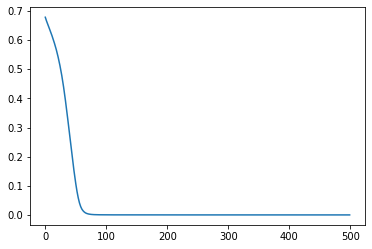


SET: rnn_last, M: concat, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 85])
Actual output shape
torch.Size([50, 1])


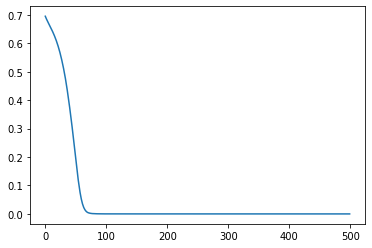


SET: rnn_last, M: mean, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 42])
Actual output shape
torch.Size([50, 1])


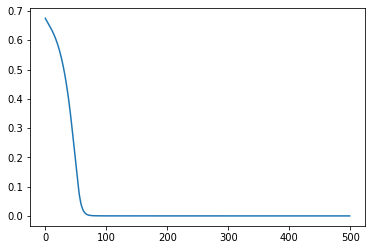


SET: rnn_last, M: mean, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 43])
Actual output shape
torch.Size([50, 1])


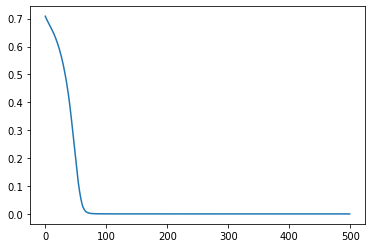


SET: rnn_last, M: sum, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 42])
Actual output shape
torch.Size([50, 1])


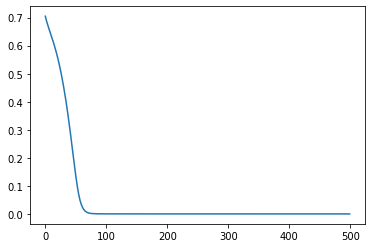


SET: rnn_last, M: sum, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 43])
Actual output shape
torch.Size([50, 1])


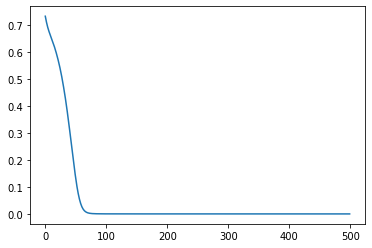


SET: rnn_mean, M: concat, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 84])
Actual output shape
torch.Size([50, 1])


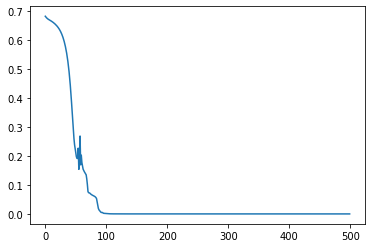


SET: rnn_mean, M: concat, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 85])
Actual output shape
torch.Size([50, 1])


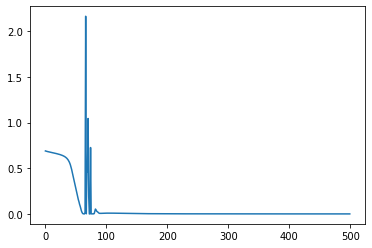


SET: rnn_mean, M: mean, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 42])
Actual output shape
torch.Size([50, 1])


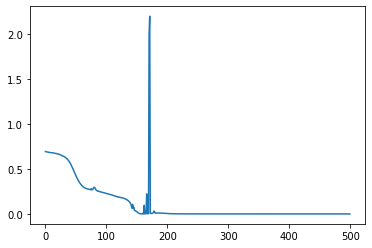


SET: rnn_mean, M: mean, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 43])
Actual output shape
torch.Size([50, 1])


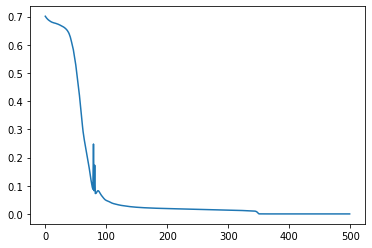


SET: rnn_mean, M: sum, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 42])
Actual output shape
torch.Size([50, 1])


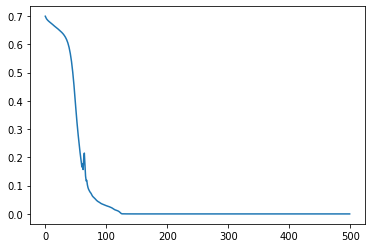


SET: rnn_mean, M: sum, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 43])
Actual output shape
torch.Size([50, 1])


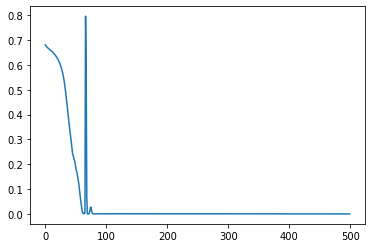


SET: mlp, M: concat, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 84])
Actual output shape
torch.Size([50, 1])


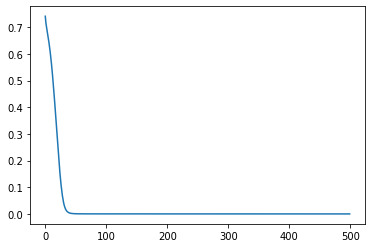


SET: mlp, M: concat, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 85])
Actual output shape
torch.Size([50, 1])


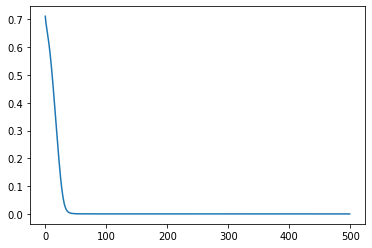


SET: mlp, M: mean, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 42])
Actual output shape
torch.Size([50, 1])


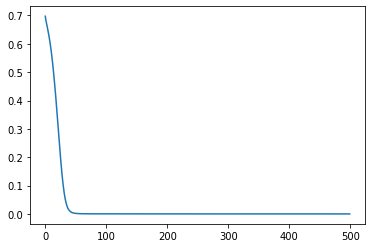


SET: mlp, M: mean, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 43])
Actual output shape
torch.Size([50, 1])


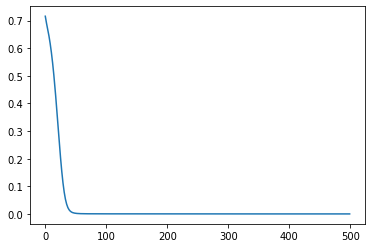


SET: mlp, M: sum, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 42])
Actual output shape
torch.Size([50, 1])


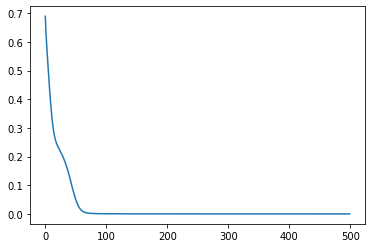


SET: mlp, M: sum, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 42])
Embedded evidences shape
torch.Size([50, 42])
Merged shape
torch.Size([50, 43])
Actual output shape
torch.Size([50, 1])


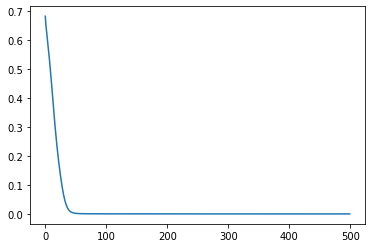


SET: bov, M: concat, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 37])
Embedded evidences shape
torch.Size([50, 37])
Merged shape
torch.Size([50, 74])
Actual output shape
torch.Size([50, 1])


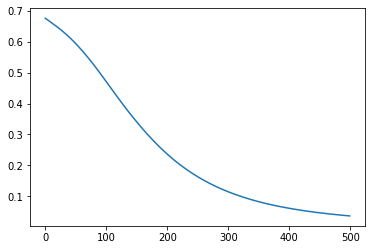


SET: bov, M: concat, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 37])
Embedded evidences shape
torch.Size([50, 37])
Merged shape
torch.Size([50, 75])
Actual output shape
torch.Size([50, 1])


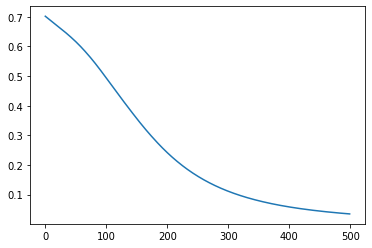


SET: bov, M: mean, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 37])
Embedded evidences shape
torch.Size([50, 37])
Merged shape
torch.Size([50, 37])
Actual output shape
torch.Size([50, 1])


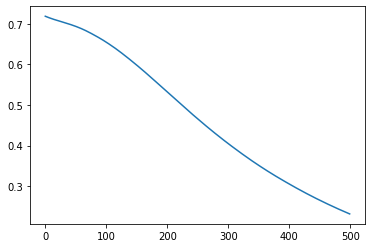


SET: bov, M: mean, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 37])
Embedded evidences shape
torch.Size([50, 37])
Merged shape
torch.Size([50, 38])
Actual output shape
torch.Size([50, 1])


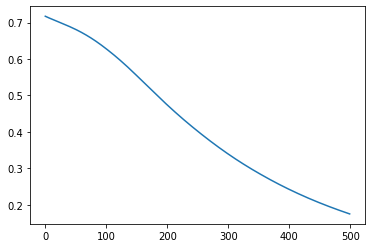


SET: bov, M: sum, C: False

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 37])
Embedded evidences shape
torch.Size([50, 37])
Merged shape
torch.Size([50, 37])
Actual output shape
torch.Size([50, 1])


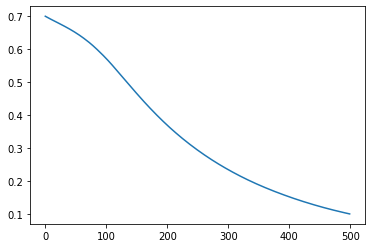


SET: bov, M: sum, C: True

Input shape
torch.Size([2, 26, 50, 37])
Output shape
torch.Size([50, 1])
Claims shape
torch.Size([26, 50, 37])
Evidences shape
torch.Size([26, 50, 37])
Embedded claims shape
torch.Size([50, 37])
Embedded evidences shape
torch.Size([50, 37])
Merged shape
torch.Size([50, 38])
Actual output shape
torch.Size([50, 1])


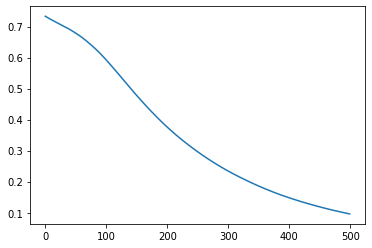

In [41]:
max_tokens = 26
embedding_dim = 37
sentence_embedding_dim = 42
classifier_hidden_dim = 12

batch_size = 50
steps=500
inputs = torch.randn(2, max_tokens, batch_size, embedding_dim)
y = torch.Tensor(np.random.randint(2, size=(batch_size,1)))

for sentence_embedding_type in ['rnn_last', 'rnn_mean', 'mlp', 'bov']:
    for merging_type in ['concat', 'mean', 'sum']:
        for add_cosine_similarity in [False, True]:
            print()
            print('='*30)
            print(f'SET: {sentence_embedding_type}, M: {merging_type}, ' 
                  f'C: {add_cosine_similarity}')
            print('='*30)
            print()
            model = FactCheckingModel(
                max_tokens, 
                embedding_dim, 
                sentence_embedding_type,
                sentence_embedding_dim,
                merging_type,
                add_cosine_similarity,
                classifier_hidden_dim
                )
            print('Input shape')
            print(inputs.shape)
            print('Output shape')
            print(y.shape)
            claims, evidences = inputs
            print('Claims shape')
            print(claims.shape)
            print('Evidences shape')
            print(evidences.shape)
            c = model.claim_embedding(claims)
            print('Embedded claims shape')
            print(c.shape)
            e = model.evidence_embedding(evidences)
            print('Embedded evidences shape')
            print(e.shape)
            s = model.merging(c, e)
            print('Merged shape')
            print(s.shape)
            o = model.classifier(s)
            print('Actual output shape')
            print(o.shape)

            optimizer = Optimization(model)

            for i in range(steps):
                optimizer.train_step(inputs, y)

            if batch_size < 5:
                print('\nBefore Training')
                print(o)

                output = model(inputs)
                print('After Training')
                print(output)
                print('Expected')
                print(y)

            plt.plot(optimizer.history)
            plt.show()

# Training

In [16]:
class Optimization:
    def __init__(self, model, learning_rate=1e-3):
        self.model = model
        self.loss_fn = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        self.history = []
    
    def train_step(self, x, y):
        self.model.train()
        yhat = self.model(x)

        loss = self.loss_fn(yhat, y)
        self.history.append(loss.item())
        loss.backward()

        self.optimizer.step()
        self.optimizer.zero_grad()

        return loss.item()

In [ ]:
def training_loop(model: nn.Module, 
                  train_set: torch.utils.data.DataLoader,
                  val_set: torch.utils.data.DataLoader,
                  n_epochs: int,
                  optimization: Optimization,
                  save_path: str,
                  load_model: bool,
                  load_path: str,
                  writer: SummaryWriter):
  
    if load_model:
        model.load_state_dict(torch.loda(load_path))

    train_acc = np.zeros(n_epochs)
    val_acc = np.zeros(n_epochs)
    best_acc = 0

    for epoch in range(n_epochs):
        print(f'Epoch {epoch+1}')

        for data in tqdm(train_set):
            w = data['words'].float().to(device)
            l = data['labels'].to(device)
            optimization.train_step(w, l)

        print(f'loss:{optimization.history[epoch] : .3f}')
        train_acc[epoch] = accuracy(model, train_set)
        print(f'train acc:{train_acc[epoch]}')
        val_acc[epoch] = accuracy(model, val_loader)
        print(f'val acc:{val_acc[epoch]}')

        writer.add_scalars('Loss', {"Train": optimization.history[epoch]}, epoch)
        writer.add_scalars('Train Acc', {"Train": val_acc[epoch]}, epoch)
        writer.add_scalars('Val Acc', {"Train": val_acc[epoch]}, epoch)
        writer.flush()

        if val_acc[epoch] > best_acc:
            torch.save(model.state_dict(), save_path)
            best_acc = val_acc[epoch]
            print(f'Model saved at {save_path}')
        
    writer.close()
    print(f'\n Best model at epoch {np.argmax(val_acc) + 1}')

# Evaluation

# Comments/Summary